# Chapter 5

### Fine-tuning

Another widely used technique for model reuse, complementary to feature
extraction, is **fine-tuning**.

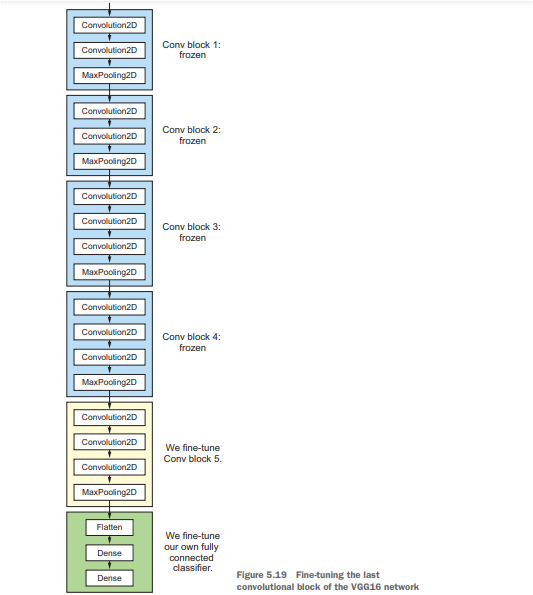

Fine-tuning consists of unfreezing a few of
the top layers of a frozen model base used for feature extraction, and jointly training
both the newly added part of the model (in this case, the fully connected classifier)
and these top layers. This is called fine-tuning because it slightly adjusts the more
abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

We stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to
be able to train a randomly initialized classifier on top. For the same reason, it’s only
possible to fine-tune the top layers of the convolutional base once the classifier on top
has already been trained. If the classifier isn’t already trained, then the error signal
propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the
steps for fine-tuning a network are as follow:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [1]:
#  Instantiating the VGG16 convolutional base

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

In [2]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
# Adding a densely connected classifier on top of the convolutional base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [9]:
# Training the model end to end with a frozen convolutional base

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
import os

base_dir = 'cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),
                                                    batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150),
                                                        batch_size=20,class_mode='binary')

Found 1000 images belonging to 2 classes.


We already completed the first three steps when doing feature extraction. Let’s proceed with step 4: 
* We'll unfreeze our `conv_base` and then freeze individual layers inside it.

We’ll fine-tune the last three convolutional layers, which means all layers **up to
block4_pool should be frozen**, and the layers **block5_conv1, block5_conv2, and
block5_conv3 should be trainable**.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base?
We could. But we need to consider the following:
* Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we’re training, the more we’re at risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on our small dataset. Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base.

In [4]:
# Freezing all layers up to a specific one

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can begin fine-tuning the network. We’ll do this with the **RMSProp** optimizer, using a very low learning rate. The **reason for using a low learning rate** is that
we want to limit the magnitude of the modifications we make to the representations
of the three layers we’re fine-tuning. Updates that are too large may harm these representation

In [8]:
# Fine-tuning the model

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

In [13]:
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=100,
                              validation_data=validation_generator,validation_steps=50)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 1123s 11s/step - loss: 0.6319 - acc: 0.6366 - val_loss: 0.3470 - val_acc: 0.8580
Epoch 2/100
100/100 [==============================] - 1276s 13s/step - loss: 0.4156 - acc: 0.8252 - val_loss: 0.2579 - val_acc: 0.8880
Epoch 3/100
100/100 [==============================] - 1177s 12s/step - loss: 0.3413 - acc: 0.8538 - val_loss: 0.2391 - val_acc: 0.8970
Epoch 4/100
100/100 [==============================] - 1533s 15s/step - loss: 0.2965 - acc: 0.8751 - val_loss: 0.2083 - val_acc: 0.9150
Epoch 5/100
100/100 [==============================] - 1241s 12s/step - loss: 0.2713 - acc: 0.8815 - val_loss: 0.1980 - val_acc: 0.9150
Epoch 6/100
100/100 [==============================] - 1265s 13s/step - loss: 0.2391 - acc: 0.9007 - val_loss: 0.1910 - val_acc: 0.9180
Epoch 7/100
100/100 [==============================] - 1250s 13s/step - loss: 0.2483 - acc: 0.8954 - val_loss: 0.1997 - val_acc: 0.9140
Epoch 8/100
100/100 [===========================

KeyboardInterrupt: 

In [15]:
# import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

These curves look noisy. To make them more readable, we can smooth them by
replacing every loss and accuracy with exponential moving averages of these quantities

In [16]:
# Smoothing the plots

# def smooth_curve(points, factor=0.8):
#     smoothed_points = []
#     for point in points:
#         if smoothed_points:
#             previous = smoothed_points[-1]
#             smoothed_points.append(previous * factor + point * (1 - factor))
#         else:
#             smoothed_points.append(point)
#         return smoothed_points

In [17]:
# plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
# plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs,smooth_curve(loss), 'bo', label='Smoothed training loss')
# plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

The validation accuracy curve look much cleaner. We’re seeing a nice 1% absolute
improvement in accuracy, from about `96%` to above `97%`.
 
Note that the loss curve doesn’t show any real improvement (in fact, it’s deteriorating). We may wonder, how could accuracy stay stable or improve if the loss isn’t
decreasing? 

The answer is simple: what we display is an average of pointwise loss values; but what matters for accuracy is the distribution of the loss values, not their average, because accuracy is the result of a binary thresholding of the class probability
predicted by the model. The model may still be improving even if this isn’t reflected
in the average loss.
 
We can now finally evaluate this model on the test data:

In [18]:
# test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150, 150),
#                                                   batch_size=20,class_mode='binary')


In [19]:
# test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
# print('test acc:', test_acc)

Here we get a test accuracy of `97%`. In the original Kaggle competition around this
dataset, this would have been one of the top results. But using modern deep-learning
techniques, we managed to reach this result using only a small fraction of the training data available (about `10%`). There is a huge difference between being able to train
on `20,000` samples compared to `2,000` samples!

### Conclusion (Chapter )

Here’s what we should take away :
* Convnets are the best type of machine-learning models for computer-vision tasks. It’s possible to train one from scratch even on a very small dataset, withdecent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when we’re working with image data.
* It’s easy to reuse an existing convnet on a new dataset via feature extraction.This is a valuable technique for working with small image datasets.
* As a complement to feature extraction, we can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now we have a solid set of tools for dealing with image-classification problems—in particular with small datasets. 

### Visualizing what convnets learn

It’s often said that deep-learning models are “black boxes”: learning representations
that are difficult to extract and present in a human-readable form. Although this is
partially true for certain types of deep-learning models, it’s definitely not true for
convnets. 

The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Since 2013, a wide
array of techniques have been developed for visualizing and interpreting these representations. We won’t survey all of them, but we’ll cover three of the most accessible
and useful ones:
* **Visualizing intermediate convnet outputs (intermediate activations)**—Useful for
understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* **Visualizing convnets filters**—Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
* **Visualizing heatmaps of class activation in an image**—Useful for understanding
which parts of an image were identified as belonging to a given class, thus allowing us to localize objects in images.

For the first method—**activation visualization**—we’ll use the small convnet that we
trained from scratch on the **dogs-versus-cats classification** problem . For
the next two methods, we’ll use the **VGG16 model**. 

### Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the feature maps that are
output by various convolution and pooling layers in a network, given a certain input
(the **output of a layer is often called its activation**, the **output of the activation function**). 

This gives a view into how an input is decomposed into the different filters
learned by the network. We want to visualize feature maps with three dimensions:
* width, 
* height, and 
* depth (channels). 

Each channel encodes relatively independent
features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image. Let’s start by loading the model that
we saved

In [61]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

Next, we’ll get an input image—a picture of a cat, not part of the images the network
was trained on.

In [63]:
#  Preprocessing a single image

img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image # Preprocesses the image into a 4D tensor
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
 
print(img_tensor.shape) # Its shape is (1, 150, 150, 3)

(1, 150, 150, 3)


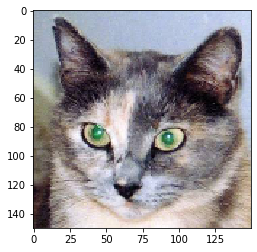

In [64]:
# Displaying the test picture

import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we’ll create a **Tensorflow/Keras** model
that takes batches of images as input, and outputs the activations of all convolution and
pooling layers. 

To do this, we’ll use the **Tensorflow/Keras** class Model. A model is instantiated
using two arguments: 
* an input tensor (or list of input tensors) and 
* an output tensor (or list of output tensors). 

The resulting class is a Tensorflow/Keras model, just like the Sequential
models we’re familiar with, mapping the specified inputs to the specified outputs.

What sets the Model class apart is that it allows for models with multiple outputs, unlike
Sequential.

In [65]:
# Instantiating a model from an input tensor and a list of output tensors

from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # Extracts the outputs of the top eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

When fed an image input, this model returns the values of the layer activations in the
original model. This is the first time we’ve encountered a multi-output model in this
book: until now, the models we’ve seen have had exactly one input and one output.

In the general case, a model can have any number of inputs and outputs. This one has
one input and eight outputs: one output per layer activation.

In [66]:
#  Running the model in predict mode

activations = activation_model.predict(img_tensor)

# Returns a list of five Numpy arrays: one array per layer activation

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


For instance, this is the activation of the first convolution layer for the cat image input:

In [67]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It’s a `148 × 148` feature map with `32` channels. Let’s try plotting the fourth channel of
the activation of the first layer of the original model

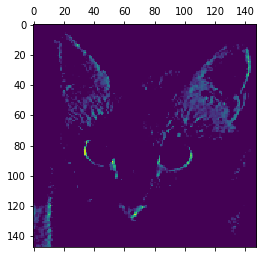

In [68]:
# Visualizing the fourth channel

import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

This channel appears to encode a diagonal edge detector. Let’s try the seventh channel —but note that our own channels may vary, because the specific filters learned by convolution layers aren’t deterministic.

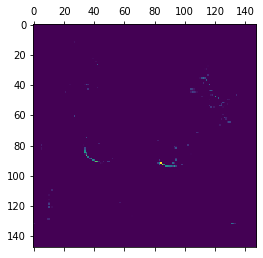

In [69]:
# Visualizing the seventh channel

plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

This one looks like a **bright green dot** detector, useful to encode cat eyes. At this
point, let’s plot a complete visualization of all the activations in the network . We’ll extract and plot every channel in each of the eight activation maps,
and we’ll stack the results in one big image tensor, with channels stacked side by side.

In [70]:
# Visualizing every channel in every intermediate activation

layer_names = [] # Names of the layers, so we can have them as part of our plot

for layer in model.layers[:8]:
    layer_names.append(layer.name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


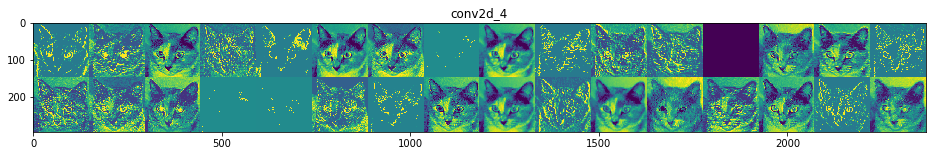

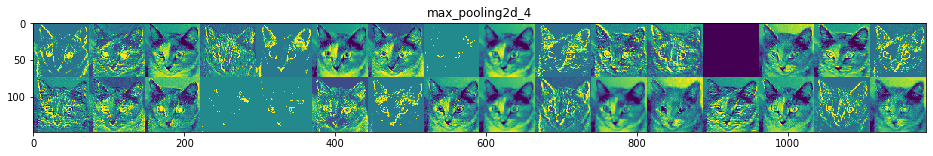

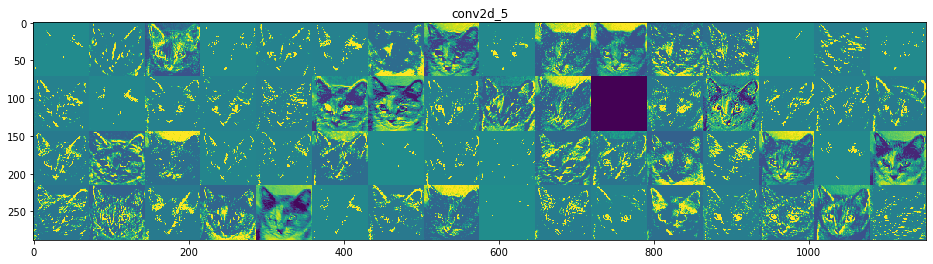

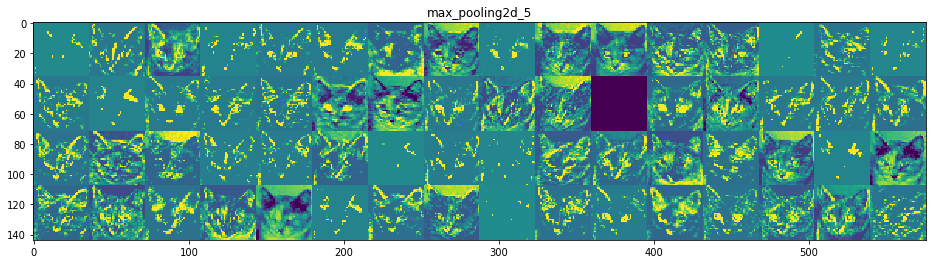

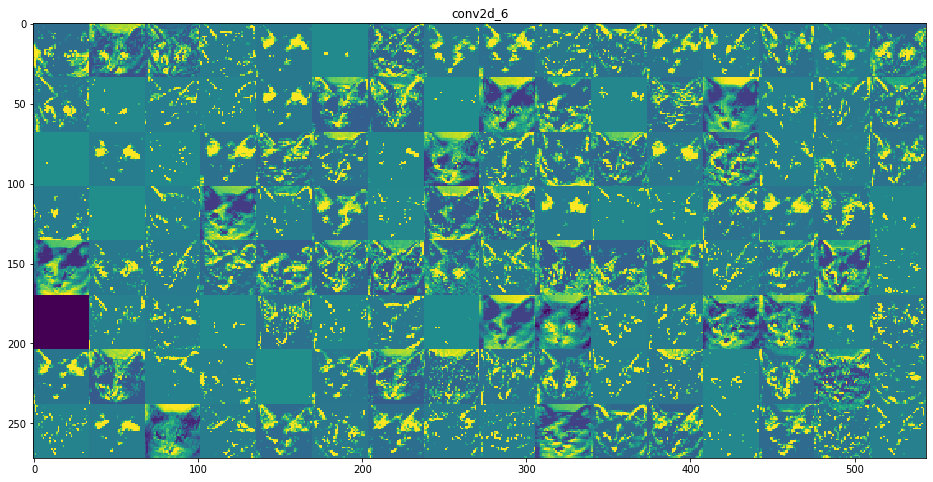

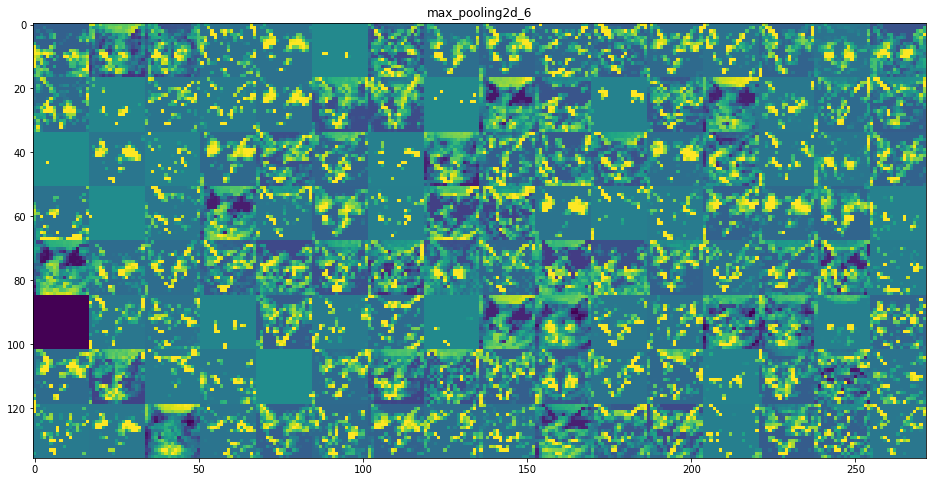

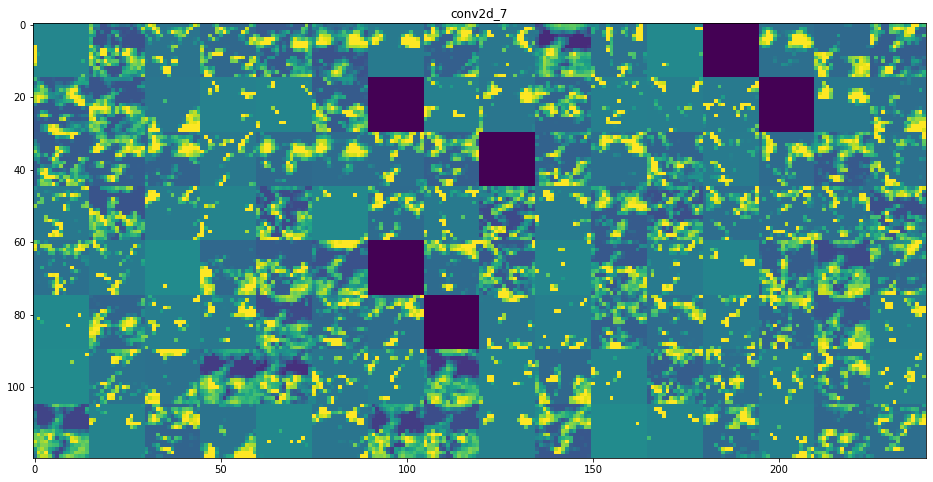

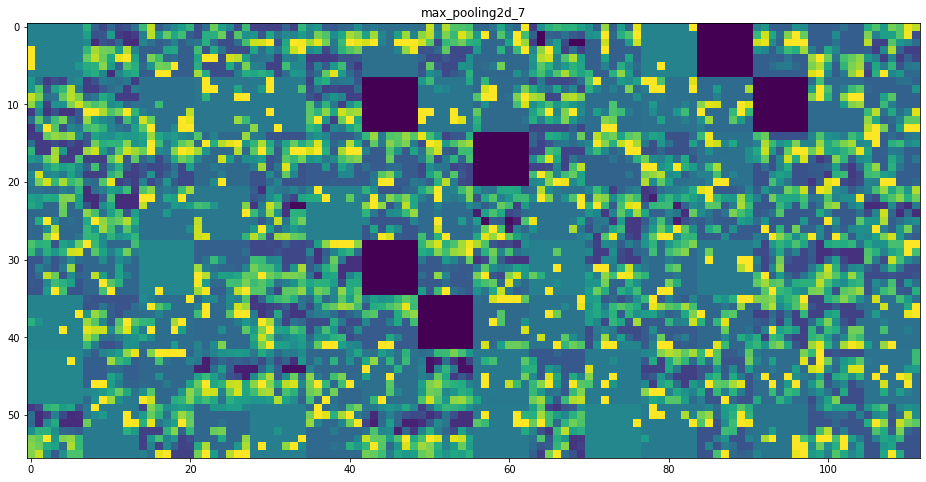

In [71]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] # The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image # Displays the grid
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As we go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as **cat ear** and **cat eye**. Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

We have just evidenced an important universal characteristic of the representations
learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. 

The activations of higher layers carry less
and less information about the specific input being seen, and more and more information about the target (in this case, the class of the image: cat or dog).

A deep neural network effectively acts as an information distillation pipeline, with raw data going in (in this case, RGB pictures) and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and
useful information is magnified and refined (for example, the class of the image).
 
This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were
present in it (bicycle, tree) but can’t remember the specific appearance of these
objects. 

In fact, if we tried to draw a generic bicycle from memory, chances are we
couldn’t get it even remotely right, even though we’ve seen thousands of bicycles in
our lifetime .

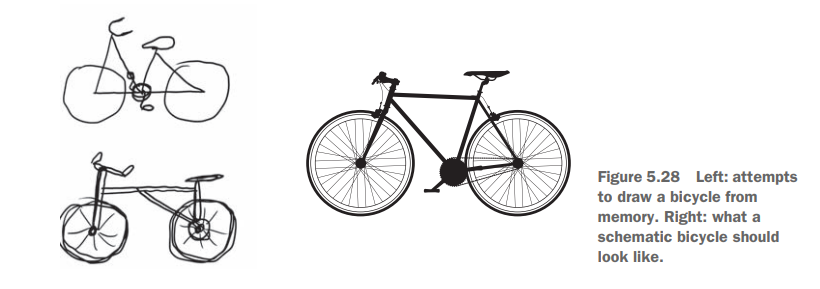

Try it right now: this effect is absolutely
real. Our brain has learned to completely abstract its visual input—to transform it into
high-level visual concepts while filtering out irrelevant visual details—making it tremendously difficult to remember how things around us look

### Visualizing convnet filters

Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with **gradient ascent in
input space**: applying gradient descent to the value of the input image of a convnet so as
to **maximize** the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.

The process is simple: we’ll build a loss function that maximizes the value of a
given filter in a given convolution layer, and then we’ll use stochastic gradient
descent to adjust the values of the input image so as to maximize this activation value.
For instance, here’s a loss for the activation of filter 0 in the layer **block3_conv1 of the
VGG16 network, pretrained on ImageNet**.

In [72]:
# Defining the loss tensor for filter visualization

from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

In [73]:
model = VGG16(weights='imagenet',include_top=False)
layer_name = 'block3_conv1'

filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we’ll need the gradient of this loss with respect to
the model’s input. To do this, we’ll use the **gradients** function packaged with the
**backend** module of **Tensorflow/Keras**.

In [74]:
# import tensorflow as tf
# tape = tf.GradientTape()

In [75]:
# tf.compat.v1.enable_eager_execution()

In [76]:
# Obtaining the gradient of the loss with regard to the input

grads = K.gradients(loss, model.input)[0]

# The call to gradients returns a list of tensors (of size 1 in this case).
# Hence, we keep only the first element— which is a tensor.

A non-obvious trick to use to help the **gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average
of the square of the values in the tensor)**. This ensures that the magnitude of the
updates done to the input image is always within the same range.

In [77]:
# Gradient-normalization trick

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Add 1e–5 before dividing to avoid accidentally dividing by 0.

Now we need a way to compute the value of the loss tensor and the gradient tensor,
given an input image. We can define a Keras backend function to do this: 
* `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: 
    * the loss value and 
    * the gradient value.

In [79]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point, we can define a Python loop to do stochastic gradient descent.

In [80]:
# Loss maximization via stochastic gradient descent

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128 # Starts from a gray image with some noise
step = 1. # Magnitude of each gradient update

for i in range(40):
    loss_value, grads_value = iterate([input_img_data]) # Computes the loss value and gradient value
    
    # Bleow we run gradientascent for 40 steps
    input_img_data += grads_value * step # here "step" adjusts the input image in the direction that maximizes the loss

The resulting image tensor is a floating-point tensor of shape `(1, 150, 150, 3)`, with
values that may not be integers within `[0, 255]`. Hence, we need to postprocess this
tensor to turn it into a displayable image. We do so with the following straightforward
utility function.

In [81]:
# Utility function to convert a tensor into a valid image

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1  # Normalizes the tensor: centers on 0, ensures that std is 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1) # Clips to [0, 1]
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x # Converts to an RGB array

Now you have all the pieces. Let’s put them together into a Python function that takes
as input a layer name and a filter index, and returns a valid image tensor representing
the pattern that maximizes the activation of the specified filter.

In [82]:
# Function to generate filter visualizations

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index]) # Builds a loss function that maximizes the activation of the nth filter of the layer under consideration
    
    grads = K.gradients(loss, model.input)[0] # Computes the gradient of the input picture with regard to this loss
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Normalization trick: normalizes the gradient
    iterate = K.function([model.input], [loss, grads]) # Returns the loss and grads given the input picture
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. # Starts from a gray image with some noise
    
    step = 1. # Runs gradient ascent for 40 steps
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

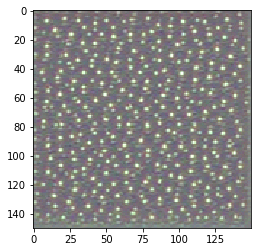

In [83]:
plt.imshow(generate_pattern('block3_conv1', 0))

It seems that filter 0 in layer `block3_conv1` is responsive to a polka-dot pattern. Now
the fun part: we can start visualizing every filter in every layer. For simplicity, we’ll
only look at the first 64 filters in each layer, and we’ll only look at the first layer of
each convolution block (`block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`,`block5_conv1`). 

We’ll arrange the outputs on an `8 × 8` grid of `64 × 64` filter patterns, with some black margins between each filter pattern 

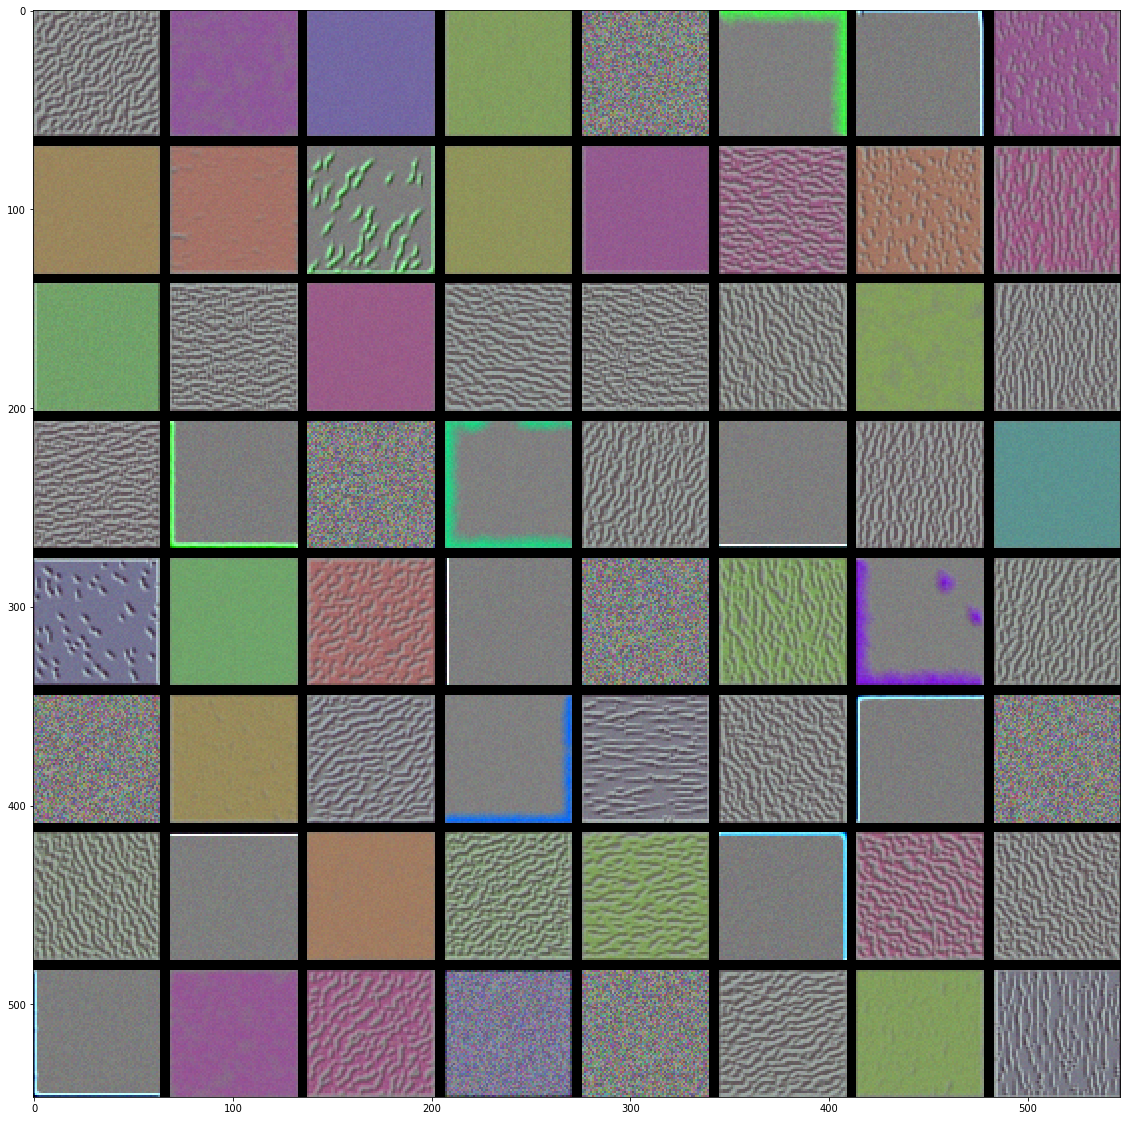

In [102]:
# Generating a grid of all filter response patterns in a layer

layer_name = 'block1_conv1'
size = 64
margin = 5
results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3)) # Empty (black) image to store result

for i in range(8): # Iterates over the rows of the results grid
    for j in range(8): # Iterates over the columns of the results grid
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) # Generates the pattern for filter i + (j * 8) in layer_name
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        # Puts the result in the square (i, j) of the results grid
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
        
# Displays the results grid

plt.figure(figsize=(20, 20))
plt.imshow(results/255)

Similary, we can also plot `block2_conv1`, `block3_conv1` and so on

These filter visualizations tell us a lot about how convnet layers see the world: each
layer in a convnet learns a collection of filters such that their inputs can be expressed
as a combination of the filters. 

This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks
get increasingly complex and refined as we go higher in the model:
* The filters from the first layer in the model (`block1_conv1`) encode simple
directional edges and colors (or colored edges, in some cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher layers begin to resemble textures found in natural images:
    * feathers, 
    * eyes, 
    * leaves, and so on. 

### Visualizing heatmaps of class activation

We’ll introduce one more visualization technique: one that is useful for understanding
which parts of a given image led a convnet to its final classification decision. This is
helpful for debugging the decision process of a convnet, particularly in the case of a
classification mistake. It also allows us to locate specific objects in an image.
 
This general category of techniques is called **class activation map (CAM)** visualization,
and it consists of producing heatmaps of class activation over input images. 
* A class activation heatmap is a 2D grid of scores associated with a specific output class, computed
for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogs versus-cats convnet, CAM visualization allows us to generate a heatmap for the class
**cat**, indicating how cat-like different parts of the image are, and also a heatmap for the
class **dog**, indicating how dog-like parts of the image are.

The specific implementation we’ll use is the one described in **Grad-CAM: Visual
Explanations from Deep Networks via Gradient-based Localization**.
It’s very simple:

* It consists of taking the output feature map of a convolution layer, given an input
image, and weighing every channel in that feature map by the gradient of the class
with respect to the channel. Intuitively, one way to understand this trick is that we’re
weighting a spatial map of 
    * **how intensely the input image activates different channels** by 
    * **how important each channel is with regard to the class**, resulting in a spatial map of 
    * **how intensely the input image activates the class**.
 
We’ll demonstrate this technique using the pretrained VGG16 network again.

In [92]:
# Loading the VGG16 network with pretrained weights

from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

# Note that we include the densely connected classifier on top; in all previous cases, we discarded it.

553467904/553467096 [==============================] - 636s 1us/step


Consider the image of two African elephants (under a Creative
Commons license), possibly a mother and her calf, strolling on the savanna.

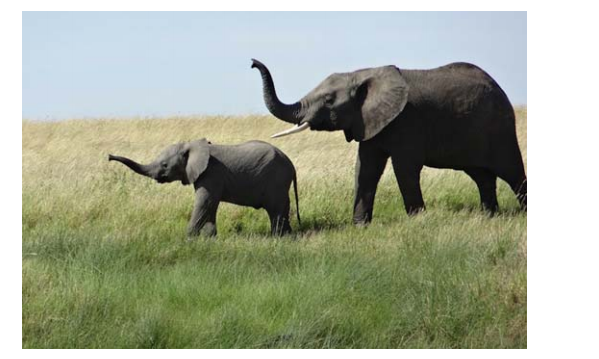

Let’s convert this image into something the VGG16 model can read: the model was trained on
images of size `224 × 244`, preprocessed according to a few rules that are packaged in the utility function `tensorflow.keras.applications.vgg16.preprocess_input`. So we need to
* Load the image, resize it to `224 × 224`, 
* Convert it to a Numpy float32 tensor, and 
* Apply these preprocessing rules.

In [93]:
# Preprocessing an input image for VGG16

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224)) # Python Imaging Library (PIL) image of size 224 × 224
x = image.img_to_array(img) # float32 Numpy array of shape (224, 224, 3)
x = np.expand_dims(x, axis=0) # Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = preprocess_input(x) # Preprocesses the batch (this does channel-wise color normalization)

We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [95]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.6218798), ('n01871265', 'tusker', 0.31403667), ('n02504013', 'Indian_elephant', 0.06385642)]


The top three classes predicted for this image are as follows:
* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

The network has recognized the image as containing an undetermined quantity of
African elephants. The entry in the prediction vector that was maximally activated is
the one corresponding to the **African elephant** class, at index 386:

In [96]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African elephant–like, let’s set up
the Grad-CAM process.

In [98]:
# Setting up the Grad-CAM algorithm

african_elephant_output = model.output[:, 386] # “African elephant” entry in the prediction vector

# Output feature map of the block5_conv3 layer, the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3') 

# Gradient of the “African elephant” class with regard to the output feature map of block5_conv3
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] 

# Vector of shape (512,), where each entry is the mean intensity of the gradient over 
# a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Lets you access the values of the quantities we just defined: 
# pooled_grads and the output feature map of block5_conv3, given a sample image
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

# Values of these two quantities, as Numpy arrays, given the sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

In [99]:
for i in range(512):
    # Multiplies each channel in the feature-map array by 
    # “how important this channel is” with regard to the “elephant” class
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purposes, we’ll also normalize the heatmap between 0 and 1

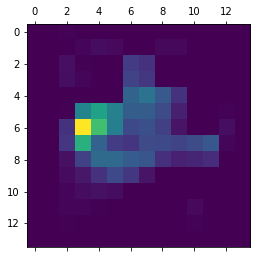

In [100]:
# Heatmap post-processing

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

Finally, we’ll use **OpenCV** to generate an image that superimposes the original image
on the heatmap we just obtained 

In [101]:
# Superimposing the heatmap with the original picture

import cv2

img = cv2.imread(img_path) # Uses cv2 to load the original image

# Resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap) # Converts the heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Applies the heatmap to the original image
superimposed_img = heatmap * 0.4 + img # 0.4 here is a heatmap intensity factor.

cv2.imwrite('elephant_cam.jpg', superimposed_img) # Saves the image to disk

True

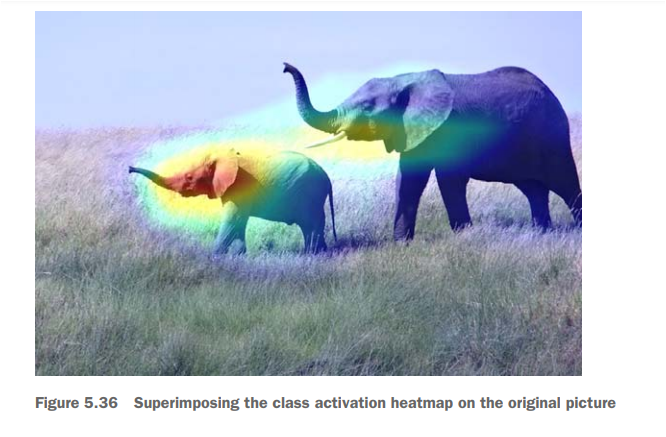

This visualization technique answers two important questions:
* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and
Indian elephants. 

### Summary

* Convnets are the best tool for attacking visual-classification problems.
* Convnets work by learning a hierarchy of modular patterns and concepts
to represent the visual world.
* The representations they learn are easy to inspect—convnets are the
opposite of black boxes!
* We’re now capable of training our own convnet from scratch to solve an
image-classification problem.
* We understand how to use visual data augmentation to fight overfitting.
* We know how to use a pretrained convnet to do feature extraction and
fine-tuning.
* We can generate visualizations of the filters learned by your convnets, as
well as heatmaps of class activity.